# Scraping Content from Results

This section will be used to parse the results file in `data/` and create a csv with the required outputs.

In [1]:
import numpy as np
import pandas as pd
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common.exceptions import WebDriverException

# Actualidad

In [11]:
with open('../data/actualidad_example_4.txt', mode='r', encoding='utf-8') as f:
    soup = BeautifulSoup(f.read())

In [ ]:
text = soup.find(name='div', attrs={'class':'Text-root Text-type_5 ArticleView-text ViewText-root'})
if not text:
    text = soup.find(name='div', attrs={'class':'amp-pages__text text', 'itemprop':'articleBody'})
text.text

'El presidente de Rusia, Vladímir Putin, se mostró este miércoles a favor de desarrollar un proceso para reconocer mutuamente los certificados de vacunación contra el coronavirus de los diferentes países de mundo, informa Interfax."Rusia procura aportar una auténtica contribución a la solución del problema de garantizar el acceso libre y no discriminatorio a las vacunas contra el covid-19 para los ciudadanos de todos los países. Abogamos por el desarrollo de un procedimiento de reconocimiento mutuo de los certificados de vacunación", dijo el mandatario en su discurso con motivo de la cumbre de Asia Oriental. Read moreMinisterio de Salud de Rusia: Se han eliminado todas las barreras para el registro de la Sputnik V en la OMSSegún estima Putin, en las condiciones actuales, la libertad de movimiento se hace prácticamente imposible sin ese reconocimiento de los certificados de inoculación.En este contexto, recordó que el uso de la vacuna rusa Sputnik V ya ha sido aprobado en 70 países del 

In [ ]:
# tags = soup.find(name='ul', attrs={'class':'Tags-list Tags-default'})
tags = soup.find_all(name='a', attrs={'class':'Tags-link'})
[tag.text for tag in tags]

['Coronavirus', 'Enfermedades', 'Reino Unido', 'internacional']

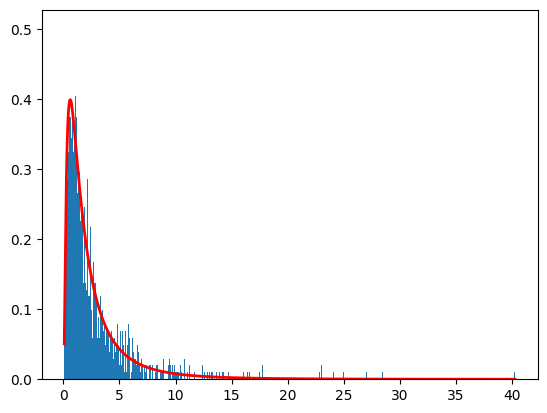

In [ ]:
# Get urls
df = pd.read_csv('../data/gdelt_actualidad_20201201_20211130.csv')
df['text'] = None
df['pull_time'] = None
df['tags'] = None

# Set sleep times
mu, sigma = 0.5, 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, df.shape[0])

# Optionally plot sleep times
def plot_sleep_times(s=s):
    import matplotlib.pyplot as plt
    count, bins, ignored = plt.hist(s, 600, density=True, align='mid')

    x = np.linspace(min(bins), max(bins), 10000)
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
        / (x * sigma * np.sqrt(2 * np.pi)))

    plt.plot(x, pdf, linewidth=2, color='r')
    plt.axis('tight')
    plt.show()
    return
if False:
    plot_sleep_times()

In [4]:
def refresh_driver(driver:webdriver.Firefox=None, e:Exception=None):
    if e:
        print(f'Refreshing driver after exception {e}.')
    else:
        print('Refreshing driver.')
    if driver:
        try:
            driver.quit()
        except WebDriverException as e:
            print('No driver to quit.')
    new_driver = webdriver.Firefox()
    return new_driver

In [14]:
# Initialize driver
driver = refresh_driver()

# filter out the urls that have successfully been pulled already and store in temporary dataframe
temp_df = df.loc[(df['text'].isna()) | (df['pull_time'].isna()) | (df['tags'].isna())]
print(f'Expected time to completion: {sum(s[:temp_df.shape[0]])} seconds')

# on by one, visit site, pull source, and store tags of interest in the original dataframe
for i, row_url in enumerate(temp_df['url']):
    df_index = df.loc[df['url']==row_url].index.values[0]
    df.at[df_index, 'pull_time'] = time.strftime('%Y-%m-%dT%H:%M:%S', time.gmtime())
    try:
        driver.get(row_url)
    except WebDriverException as e:
        df.at[df_index, 'text'] = f'[ERROR] The url is not reachable at this time.'
        df.at[df_index, 'tags'] = f'[ERROR] The url is not reachable at this time.'
        driver = refresh_driver(driver=driver, e=e)
        continue
    soup = BeautifulSoup(driver.page_source)

    # Get tags
    tags = soup.find_all(name='a', attrs={'class':'Tags-link'})    
    if tags:
        df.at[df_index, 'tags'] = [tag.text for tag in tags]
    else:
        df.at[df_index, 'tags'] = 'No tags found.'

    # Get text
    text = soup.find(name='div', attrs={'class':'Text-root Text-type_5 ArticleView-text ViewText-root'})
    if not text:    
        text = soup.find(name='div', attrs={'class':'amp-pages__text text', 'itemprop':'articleBody'})
    if text:
        df.at[df_index, 'text'] = text.text
    
    # Track Progress
    if i%300 == 0:
        print(f'{round(i/temp_df.shape[0]*100)}% of {temp_df.shape[0]} completed...')
        if i != 0:
            driver = refresh_driver(driver=driver)
    time.sleep(s[i])
driver.quit()
if sum(df['text'].isna()) or sum(df['pull_time'].isna()) or sum(df['tags'].isna()):
    df.to_csv(f'../temp/actualidad_partial_results_{time.strftime('%Y_%m_%d_%H%M%S', time.gmtime())}.csv', index=False)
    df.to_csv(f'../temp/actualidad_partial_results_latest.csv', index=False)
    print('[WARNING] Some results were not pulled. Partial results were saved to "../temp/actualidad_partial_results_latest.csv". Please run this cell again after correcting the errors.')
else:
    df.to_csv(f'../data/actualidad_full_results_{time.strftime('%Y_%m_%d_%H%M%S', time.gmtime())}.csv', index=False)
    print('[SUCCESS] Results were saved to "../data/actualidad_full_results_<date>.csv".')


Refreshing driver.
Expected time to completion: 2.5143004661216546 seconds
0% of 1 completed...
[SUCCESS] Results were saved to "../data/actualidad_full_results_<date>.csv".


In [7]:
dup_counts = df.groupby(['text'], as_index=False, dropna=False).size().sort_values('size')
dups = dup_counts.loc[dup_counts['size']>1]
dups

,text,size
80,Brasil aplicó este domingo su primera vacuna c...,2
1136,La vacuna rusa Sputnik V garantiza una inmunid...,2


## Sputnik Globe

In [ ]:
# Get urls
df = pd.read_csv('../data/results_sputnikglobe_20201201_20211130.csv')
df['text'] = None
df['pull_time'] = None
df['keywords'] = None
df['analytics_keywords'] = None

# Set sleep times
mu, sigma = 0.5, 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, df.shape[0])

# Optionally plot sleep times
def plot_sleep_times(s=s):
    import matplotlib.pyplot as plt
    count, bins, ignored = plt.hist(s, 600, density=True, align='mid')

    x = np.linspace(min(bins), max(bins), 10000)
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
        / (x * sigma * np.sqrt(2 * np.pi)))

    plt.plot(x, pdf, linewidth=2, color='r')
    plt.axis('tight')
    plt.show()
    return
if False:
    plot_sleep_times()

In [ ]:
# Initialize driver
driver = refresh_driver()

# filter out the urls that have successfully been pulled already and store in temporary dataframe
temp_df = df.loc[(df['text'].isna()) | (df['pull_time'].isna()) | (df['keywords'].isna()) | (df['analytics_keywords'].isna())]

# on by one, visit site, pull source, and store tags of interest in the original dataframe
for i, row_url in enumerate(temp_df['url']):
    df_index = df.loc[df['url']==row_url].index.values[0]
    df.at[df_index, 'pull_time'] = time.strftime('%Y-%m-%dT%H:%M:%S', time.gmtime())
    try:
        driver.get(row_url)
    except WebDriverException as e:
        df.at[df_index, 'text'] = f'[ERROR] The url is not reachable at this time.'
        df.at[df_index, 'keywords'] = f'[ERROR] The url is not reachable at this time.'
        df.at[df_index, 'analytics_keywords'] = f'[ERROR] The url is not reachable at this time.'
        driver = refresh_driver(driver=driver, e=e)
        continue
    soup = BeautifulSoup(driver.page_source)
    url_keywords = soup.find(name='meta', attrs={'name':'keywords'})
    if url_keywords:
        df.at[df_index, 'keywords'] = url_keywords['content']
    else:
        df.at[df_index, 'keywords'] = 'No keywords found.'
    url_analytics_keywords = soup.find(name='meta', attrs={'name':'analytics:keyw'})
    if url_analytics_keywords:
        df.at[df_index, 'analytics_keywords'] = url_analytics_keywords['content']
    else:
        df.at[df_index, 'analytics_keywords'] = 'No analytics keywords found.'
    text_header = soup.find(name='div', attrs={'class':'article__announce-text'})
    text_body = soup.find(name='div', attrs={'class':'article__body'})
    if text_header:
        text = text_header.text
    else:
        text = ''
    if text_body:
        text += text_body.text
    df.at[df_index, 'text'] = text
    if i%300 == 0:
        print(f'{round(i/temp_df.shape[0]*100)}% of {temp_df.shape[0]} completed...')
        driver = refresh_driver(driver=driver)
    time.sleep(s[i])
driver.quit()
if sum(df['text'].isna()) or sum(df['pull_time'].isna()) or sum(df['keywords'].isna()):
    df.drop('Unnamed: 0', axis=1).to_csv(f'../data/sputnik_partial_results_{time.strftime('%Y_%m_%d_%H%M%S', time.gmtime())}.csv', index=False)
    print('[WARNING] Some results were not pulled. Partial results were saved to "../data/sputnik_partial_results_<date>.csv". Please run this cell again after correcting the errors.')
else:
    df.drop('Unnamed: 0', axis=1).to_csv(f'../data/sputnik_full_results_{time.strftime('%Y_%m_%d_%H%M%S', time.gmtime())}.csv', index=False)
    print('[SUCCESS] Results were saved to "../data/sputnik_full_results_<date>.csv".')


[SUCCESS] Results were saved to "../data/sputnik_full_results_<date>.csv".


Checking to see if things look okay.

In [142]:
df.head()

,Unnamed: 0,date,url,title,text,pull_time,keywords,analytics_keywords
0,0,20210430,https://sputnikglobe.com/20210430/biden-us-mil...,Biden: US Military Brass Will Decide Whether t...,"Since the onset of the COVID-19 pandemic, the ...",2025-04-12T21:46:33,"military & intelligence, newsfeed, joe biden, ...","military, news, tag_JoeBiden, organization_US_..."
1,1,20210430,https://sputnikglobe.com/20210430/russian-vacc...,Russian Vaccines Protect From All Known Strain...,MOSCOW (Sputnik) - The immunity developed afte...,2025-04-13T22:51:48,"newsfeed, russia","news, world, russia, geo_Russia, covid-19, key..."
2,2,20210430,https://sputnikglobe.com/20210430/hope-theres-...,‘Hope There's No Quid Pro Quo’: Is US Expectin...,The US said on Thursday that it would send med...,2025-04-12T21:46:50,"newsfeed, china, joe biden, afghanistan, us","world, news, geo_China, tag_JoeBiden, covid-19..."
3,3,20210430,https://sputnikglobe.com/20210430/albania-appr...,Albania Approves Use of Russian COVID-19 Vacci...,MOSCOW (Sputnik) - Albania has approved the us...,2025-04-12T21:46:54,"newsfeed, russian direct investment fund (rdif...","news, world, tag_RussianDirectInvestmentFundRD..."
4,4,20210430,https://sputnikglobe.com/20210430/yogi-adityan...,Will Yogi Adityanath Fight Back After Supreme ...,"The Indian government, led by Prime Minister N...",2025-04-12T21:47:01,"newsfeed, indians, coronavirus, supreme court,...","news, world, keyword_Indians, organization_Ind..."


Checking for duplicates

In [152]:
dup_counts = df.groupby(['text', 'keywords', 'analytics_keywords'], as_index=False, dropna=False).size().sort_values('size')
dups = dup_counts.loc[dup_counts['size']>1]
dups

,text,keywords,analytics_keywords,size
2021,MOSCOW (Sputnik) - The Russian coronavirus Epi...,"newsfeed, russia, rospotrebnadzor","russia, world, news, geo_Russia, tag_Rospotreb...",2


Use the following cell to walk through one by one to see if anything stands out as odd.

In [153]:
df.loc[df.keywords==dups.iloc[0]['keywords']]

,Unnamed: 0,date,url,title,text,pull_time,keywords,analytics_keywords
767,767,20201229,https://sputnikglobe.com/20201229/russian-epiv...,Russian EpiVacCorona Vaccine Has No Negative E...,MOSCOW (Sputnik) - The Russian coronavirus Epi...,2025-04-13T23:28:51,"newsfeed, russia, rospotrebnadzor","russia, world, news, geo_Russia, tag_Rospotreb..."
768,768,20201229,https://sputnikglobe.com/20201229/production-o...,Production of COVID-19 Vaccines in Russia Exce...,MOSCOW (Sputnik) - The Russian coronavirus Epi...,2025-04-13T23:28:58,"newsfeed, russia, rospotrebnadzor","russia, world, news, geo_Russia, tag_Rospotreb..."


Weird-looking urls: 
- [text in a box](https://sputnikglobe.com/20210825/live-updates-16-evacuees-from-afghanistan-test-positive-for-covid-19-in-india-as-delta-cases-rise-1083705747.html)
    - The boxes start at `<div class="online__item-text m-last">` and appear to be previous articles. Don't know if they should be included in text too, right now they are not included.
- [multiple texts in box](https://sputnikglobe.com/20210824/live-updates-india-covid-19-cases-rise-to-3247-million-1083697851.html)
    - same as text in a box
- [tweets](https://sputnikglobe.com/20210823/seven-members-of-dalit-family-in-india-severely-beaten-over-black-magic-allegation-1083692603.html)
    - They are contained in `<blockquote class="twitter-tweet" align="center" data-link-color="#069">`. Don't know if they should be included in text too, right now they are not included.

Additional keywords to pull
- google_tags. E.g., `<script type="text/javascript" id="" charset="">ym(google_tag_manager["rm"]["11997873"](44),"params",{tags:{1082775132:["Military \x26 Intelligence, Newsfeed, Joe Biden, US military, COVID-19, Vaccines, US soldiers, mandate"]}});</script>`